In [1]:
import os.path

import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.interpolate import interp1d
from scipy import stats
%matplotlib inline

In [2]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [3]:
import scipy
scipy.__version__

'0.19.0'

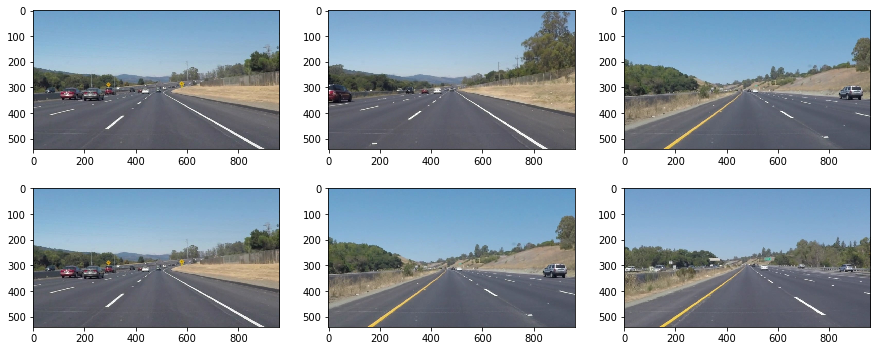

In [4]:
IMAGE_FOLDER="test_images"
images = []

for image in os.scandir(IMAGE_FOLDER):
    images.append(mpimg.imread(image.path))
    
if images:
    IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS = images[0].shape
    
# just a helper function to display a list of images
def show_images(images_to_show, row=2, col=3, fig_size=(15, 6)):
    f, axes = plt.subplots(2, 3)
    f.set_size_inches(fig_size)
    for y in range(0, row):
        for x in range(0, col):
            ax = axes[y, x]
            ax.imshow(images_to_show[(y+1) * x], cmap='gray')
            
show_images(images)

In [5]:
# keep all configurations in one place
class ImageConfig(object):
    def __init__(self, width=960, height=540):
        self.width = width
        self.height = height
    
class ColorConfig(object):
    yellow_lower = np.array([20, 20, 110])
    yellow_upper = np.array([45, 255, 255])
    white_sensitivity = 35
    white_lower = np.array([0, 0, 225 - white_sensitivity])
    white_upper = np.array([255, white_sensitivity, 255])
    
class ROI(object):
    def __init__(self, img_config, horizontal_step = 100, vertical_step = 50, bottom=0):
        self.vertices = np.array([
        [0, img_config.height - bottom],
        [img_config.width, img_config.height - bottom],
        [img_config.width/2 + horizontal_step, img_config.height/2 + vertical_step],
        [img_config.width/2 - horizontal_step, img_config.height/2 + vertical_step],], dtype='int32')

class GaussianConfig(object):
    kernel = (3, 9)
    
class DilateConfig(object):
    kernel = np.ones((3, 5),np.uint8)

class CannyConfig(object):
    # normal
    #low = 50
    #high = 150
    # challenge
    low = 30
    high = 60

class HoughConfig(object):
    rho = 1
    theta = np.pi/180
    threshold = 40
    min_line_len = 5
    max_line_gap = 3
    
class LineConfig(object):
    def __init__(self, y_bottom=540, y_top=350):
        self.mean_slope = 0.59
        self.std_slope = 0.04
        self.y_bottom = y_bottom
        self.y_top = y_top
    

class Config(object):
    def __init__(self):
        self.image = ImageConfig()
        self.smooth = GaussianConfig()
        self.dilate = DilateConfig()
        self.color = ColorConfig()
        self.roi = ROI(self.image) 
        self.canny = CannyConfig()
        self.hough = HoughConfig()
        self.line = LineConfig()
        
class ChallengeConfig(object):
    def __init__(self):
        self.image = ImageConfig(width=1280, height=720) # uncomment for challenge
        self.smooth = GaussianConfig()
        self.dilate = DilateConfig()
        self.color = ColorConfig()
        self.roi = ROI(self.image, bottom=45)
        self.canny = CannyConfig()
        self.hough = HoughConfig()
        self.line = LineConfig(y_bottom=690, y_top=460)

In [6]:
class LaneLinesDetector(object):
    def __init__(self, config):
        self.config = config
        # keep tracking of the previous lines
        self.prev_neg_line = None
        self.prev_pos_line = None
        # 
        self.memory = []
        self.max_size = 1
        
    def reset(self):
        self.memory = []
        
    def detect(self, image, annotations=True):
        # 1. Color based segmentation
        smoothed_img = cv2.GaussianBlur(image, self.config.smooth.kernel, 0)
        filtered_img = self.color_filter(smoothed_img, self.config.color, self.config.dilate)
        cropped_roi_color_img = self.crop_to_roi(filtered_img, [self.config.roi.vertices])
        
        # 2. Crop the gray image to roi and enhance the colors
        gray_img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        gray_smoothed_img = cv2.GaussianBlur(gray_img, self.config.smooth.kernel, 0)
        canny_img = cv2.Canny(gray_smoothed_img, self.config.canny.low, self.config.canny.high)
        canny_cropped_img = cv2.bitwise_and(canny_img, cropped_roi_color_img)

        hough_lines = cv2.HoughLinesP(
            canny_cropped_img, self.config.hough.rho, 
            self.config.hough.theta, self.config.hough.threshold, np.array([]),
            minLineLength=self.config.hough.min_line_len,
            maxLineGap=self.config.hough.max_line_gap)
        
        if hough_lines is not None:
            #print(hough_lines.shape)
            if len(self.memory) == self.max_size:
                self.memory = self.memory[1:]
            self.memory.append(hough_lines)
        
        if len(self.memory) < self.max_size:
            return image
        
        hough_image = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
        for hough_lines in self.memory:
            for line in hough_lines:
                for x1, y1, x2, y2 in line:
                    cv2.line(hough_image, (x1, y1), (x2, y2), 255, 15)
        
        
        # 4. Find all lines with positive and negative slopes
        positive_slopes = []
        negative_slopes = []
        mean = self.config.line.mean_slope
        std = self.config.line.std_slope
        
        for hough_lines in self.memory:
            for line in hough_lines:
                for x1, y1, x2, y2 in line:
                    a = (y2 - y1) / (x2 - x1)
                    abs_degree = abs(np.arctan(a))
                if not(mean - 3 * std <= abs_degree <= mean + 3 * std):
                    continue
                elif a > 0:
                    positive_slopes.append((x1, y1))
                    positive_slopes.append((x2, y2))
                    #positive_slopes.append((x1, y1, x2, y2))
                elif a < 0:
                    negative_slopes.append((x1, y1))
                    negative_slopes.append((x2, y2))
                    #negative_slopes.append((x1, y1, x2, y2))
                    
                
        # 5. Draw the lines to the original image
        
        #slopes = sorted(positive_slopes, key=lambda tup: tup[0])
        #x = np.asarray([v[0] for v in slopes])
        #y = np.asarray([v[1] for v in slopes])
        #return x, y
    
        line_img = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
        for slopes in [negative_slopes, positive_slopes]:
            slopes = sorted(slopes, key=lambda tup: tup[0])
            x = np.asarray([v[0] for v in slopes])
            y = np.asarray([v[1] for v in slopes])
            #slope, intercept, _, _, _ = stats.linregress(x, y)
            
            y_bottom = self.config.line.y_bottom
            y_top = self.config.line.y_top
            
            coef = np.polyfit(y, x, 1)
            p = np.poly1d(coef)
            new_y = np.linspace(y_bottom, y_top, 100)
            new_x = p(new_y)
            
            #return x, y, new_x, new_y
            
            #print(coef)
            
            #y_bottom = self.config.line.y_bottom
            #y_top = self.config.line.y_top
            #x_bottom = (y_bottom - intercept)/slope
            #x_top = (y_top - intercept)/slope
            
            for i in range(100):
                cv2.line(line_img, (int(new_x[i-1]), int(new_y[i-1])), (int(new_x[i]), int(new_y[i])), [0, 255, 0], 15)
            
        
        weighted_img = cv2.addWeighted(image, 0.8, line_img, 1.0, 0.0)
        if annotations:
            # show roi
            cropped_roi_img = self.crop_to_roi(image, [self.config.roi.vertices])
            ratio = 0.18
            resized = cv2.resize(cropped_roi_img, (0, 0), fx=ratio, fy=ratio)
            r_h, r_w, _ = resized.shape
            init_h, init_w = 10, 40
            space = 10
            images = [
                cropped_roi_img, cropped_roi_color_img, canny_img, canny_cropped_img, hough_image]
            labels = [
                'region of interest', 'color segmentation', 'canny', 'canny + color segm.', 'hough']
            for i, image in enumerate(images):
                resized = cv2.resize(image, (0, 0), fx=ratio, fy=ratio)
                if len(resized.shape) == 2:
                    resized = cv2.cvtColor(resized, cv2.COLOR_GRAY2RGB)
                weighted_img[
                    (init_h):(init_h + r_h),
                    (init_w + i * (r_w + space)) : (init_w + (i + 1) * r_w + i * space),:] = resized
                cv2.putText(
                    weighted_img,
                    labels[i], (init_w + i * (r_w + space) + 5, init_h + 15), cv2.FONT_HERSHEY_DUPLEX, 0.4, (0, 255, 0))

        return weighted_img
    
    def color_filter(self, image, color_config, dil_config):
        hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        yellow_range = cv2.inRange(hsv, color_config.yellow_lower, color_config.yellow_upper)
        white_range = cv2.inRange(hsv, color_config.white_lower, color_config.white_upper)
        merged = yellow_range + white_range
        _, thresh = cv2.threshold(merged, 100, 255, cv2.THRESH_BINARY)
        return cv2.dilate(thresh, dil_config.kernel, iterations=1)
    
    def crop_to_roi(self, img, vertices):
        mask = np.zeros_like(img)
        if len(img.shape) > 2:
            channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
            ignore_mask_color = (255,) * channel_count
        else:
            ignore_mask_color = 255
        
        cv2.fillPoly(mask, vertices, ignore_mask_color)
    
        #returning the image only where mask pixels are nonzero
        masked_image = cv2.bitwise_and(img, mask)
        return masked_image
    
    def avareged_line(self, lines, y_bottom, y_top):
        #print(lines)
        mean_lines = np.mean(np.asarray(lines), 0).astype('int32')
        slope = (mean_lines[3] - mean_lines[1])/(mean_lines[2] - mean_lines[0])
        intercept = (mean_lines[1] - slope * mean_lines[0])
        x_bottom = (y_bottom - intercept)/slope
        x_top = (y_top - intercept)/slope
        return int(x_bottom), y_bottom, int(x_top), y_top

In [8]:
detector = LaneLinesDetector(Config())
ch_detector = LaneLinesDetector(ChallengeConfig())

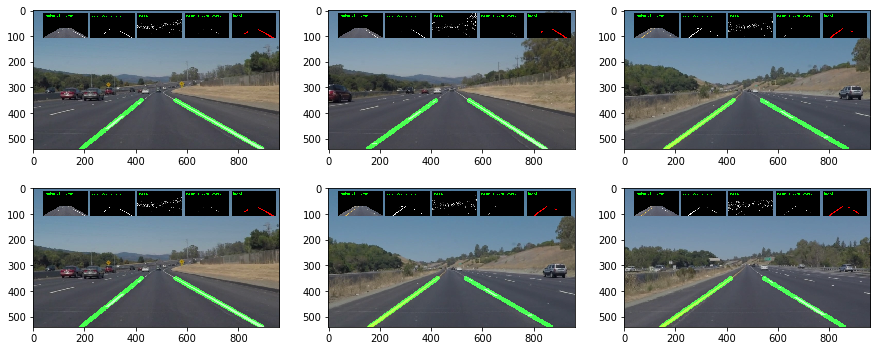

In [9]:
lines_detected = []
for image in images:
    lines_detected.append(detector.detect(image))
    
show_images(lines_detected)

In [ ]:
def process_video(input, output):
    clip1 = VideoFileClip(input)
    white_clip = clip1.fl_image(ch_detector.detect) #NOTE: this function expects color images!!
    %time white_clip.write_videofile(output, audio=False)

#detector.reset()
#process_video('test_videos/solidYellowLeft.mp4', 'test_videos_output/solidYellowLeft.mp4')
ch_detector.reset()
#process_video('test_videos/solidWhiteRight.mp4', 'test_videos_output/solidWhiteRight.mp4')
process_video('test_videos/challenge.mp4', 'test_videos_output/challenge.mp4')